<a href="https://colab.research.google.com/github/wdon021/From_Colab/blob/master/Assignment3_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
# import scipy.misc as smp
from PIL import Image as im
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image, display
import pandas as pd

### Generate dataset

In [2]:
def create_circle_random(size = 28, radius = 5, color = 255):
  k = np.random.random_sample(size=2)
  col_random = np.int(16*k[0])+6
  row_random = np.int(16*k[1])+6
  data = np.zeros((size, size), dtype = np.uint8)
  ci,cj = row_random, col_random
  cr = radius
  if(((col_random+cr)>=28) | ((col_random-cr)<1)):
    print("col_random is out of bound")
  if(((row_random+cr)>=28) | ((row_random-cr)<1)):
    print("row_random is out of bound")
  I,J = np.meshgrid(np.arange(data.shape[0]), np.arange(data.shape[1]))
  # basic formula for a circle (x - a)**2 + (y - b)**2 = r**2
  # calculate the radius
  dist = np.sqrt((I-ci)**2 +(J-cj)**2)
  # Assign value of any for those points within radius
  data[np.where(dist<cr)] = color
  # img = im.fromarray(data)
  return data.flatten()

In [3]:
def rect_x_y(height, width):
  k = np.random.random_sample(size=2)
  start_x = np.int(27*k[0])
  start_y = np.int(27*k[1])
  rows = start_x + height 
  cols = start_y + width
  return start_x, start_y, rows, cols

In [4]:
def rect_random(size, color):
  data = np.zeros((size, size), dtype = np.uint8)
  # x1, y1, x2, y2 = 0, 0, 0, 0
  x1, y1, x2, y2 = rect_x_y(4, 8)
  # print([x1, y1, x2, y2 ])
  while((x2 >=28)|(y2 >=28)):
    x1, y1, x2, y2 = rect_x_y(4, 8)
  # print([x1, y1, x2, y2 ])
  data[x1:x2, y1:y2] = color
  # img = im.fromarray(data)
  return data.flatten()
  # return img

In [5]:
def triang_ran(size, color, diagonals = -1):
  data = np.zeros((size, size), dtype = np.uint8)
  # define a rectangle
  start_x, start_y, rows, cols = rect_x_y(8, 8)
  # print([start_x, start_y, rows, cols])
  while((rows >=28)|(cols >=28)):
    start_x, start_y, rows, cols = rect_x_y(8, 8)
  # print([start_x, start_y, rows, cols])
  data[start_x:rows, start_y:cols] = color
  # return lower triangle of rectangle
  data[start_x:rows, start_y:cols] = np.tril(data[start_x:rows, start_y:cols], diagonals)
  # return upper half triangle of rectangle
  # data[start_x:rows, start_y:cols] = np.triu(data[start_x:rows, start_y:cols], diagonals)
  # img = im.fromarray(data)
  # return img
  return data.flatten()

In [6]:
def random_shape():
  data = np.array([])
  name = ""
  prob = np.random.random_sample()
  if(prob<= 0.33333333333333333):
    data = create_circle_random(28, 5, 255)
    name = "C"
  elif((prob> 0.33333333333333333) & (prob<= 0.66666666666666666)):
    data = rect_random(28, 255)
    name = "R"
  else:
    data = triang_ran(28, 255)
    name = 'T'
  return data, name

In [7]:
def random_generate(size):
  shape_vect = []
  shape_name = []
  for i in range(size):
    s_vect, s_name = random_shape()
    shape_vect.append(s_vect)
    shape_name.append(s_name)
  num_2d_shape = np.array(shape_vect).reshape(-1, 784)
  return num_2d_shape, shape_name

In [8]:
train_shape, train_name =  random_generate(1000)

In [9]:
test_shape, test_name =  random_generate(200)

#### Simple CNN with fit rather than fit_generator

In [10]:
from keras.utils.np_utils import to_categorical

Normalization  CNN converg faster on [0..1] data than on [0..255].

In [11]:
train_shape_N = train_shape/255.0
test_shape_N = test_shape/255.0

Reshape

In [12]:
train_shape_R = train_shape_N.reshape(-1, 28, 28, 1)
test_shape_R = test_shape_N.reshape(-1, 28, 28, 1)

Label Encoding + one hot encoding the y

In [14]:
# Mapping 
shape = ['C', "T", "R"]
mapping = {}
for x in range(len(shape)):
  mapping[shape[x]] = x

In [15]:
# Integer representation
for x in range(len(train_name)):
  train_name[x] = mapping[train_name[x]]

In [16]:
# one hot encoding
y = to_categorical(train_name)

split training and validation set

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(train_shape_R, y, test_size = 0.2, random_state = 0)

Data visualization

In [22]:
X_train__ = X_train.reshape(X_train.shape[0], 28, 28)

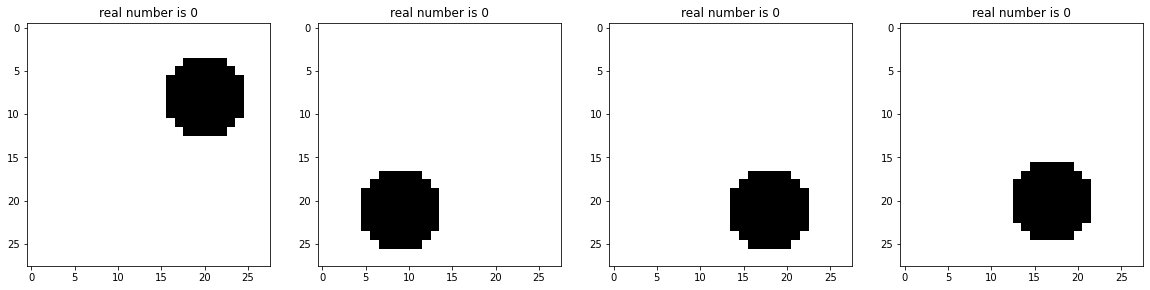

In [23]:
fig, axis = plt.subplots(1, 4, figsize = (20, 10))
for i, ax in enumerate(axis.flat):
  ax.imshow(X_train__[i], cmap = 'binary')
  digit = y_train[i].argmax()
  ax.set(title = f"real number is {digit}")

In [30]:
epoch = 10
batch_sizes = 100

Define model

In [26]:
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [37]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size= (3, 3), activation="relu", input_shape = (28, 28, 1)))
model.add(Conv2D(filters=64, kernel_size= (3, 3), activation="relu", input_shape = (28, 28, 1)))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation = 'relu'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation = 'relu'))

model.add(MaxPooling2D(pool_size= (2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [38]:
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(3, activation= "softmax"))
model.compile(loss= "categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [46]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=1, batch_size= batch_sizes)

8/8 [==============================] - 5s 669ms/step - loss: 6.1047e-04 - accuracy: 1.0000 - val_loss: 1.7832 - val_accuracy: 0.3000


fit break down using Assignment 1

In [47]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [60]:
inputs = keras.Input(shape = (28, 28, 1), name = 'shapes')
x1 = Conv2D(filters=64, kernel_size= (3, 3), activation="relu", input_shape = (28, 28, 1))(inputs)
x2 = MaxPooling2D(pool_size = (2, 2))(x1)
x3 = BatchNormalization()(x2)
x4 = Conv2D(filters=128, kernel_size=(3, 3), activation = 'relu')(x3)
x5 = MaxPooling2D(pool_size= (2, 2))(x4)
x6 = BatchNormalization()(x5)
x7 = Flatten()(x6)
x8 = BatchNormalization()(x7)
x9 = layers.Dense(64, activation = 'relu')(x8)
x10 = layers.Dense(64, activation = 'relu')(x9)
outputs = layers.Dense(3, activation="softmax")(x10)

In [61]:
model = keras.Model(inputs = inputs, outputs = outputs)

In [62]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

In [65]:
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [69]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

In [70]:
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_sizes)

In [82]:
tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits= logits, labels = y_batch_train))

<tf.Tensor: shape=(), dtype=float32, numpy=1.1042178>

In [83]:
epochs = 2
for epoch in range(epochs):
  print("\n==============start of epoch %d" %(epoch,))
  for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      logits = model(x_batch_train, training = True)
      # print(y_batch_train.shape)
      # print(logits.shape)
      loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits= logits, labels = y_batch_train))
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))


==============start of epoch 0

==============start of epoch 1


plot CNN model 

In [33]:
from keras.utils.vis_utils import plot_model

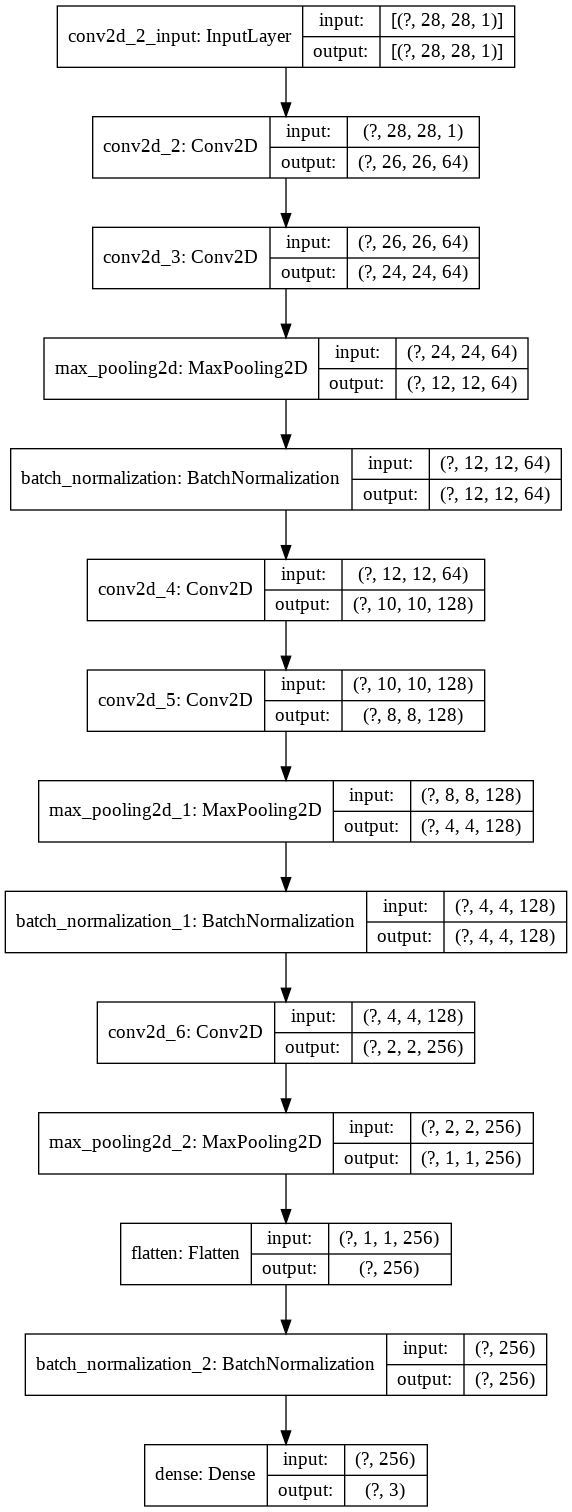

In [34]:
plot_model(model, show_shapes=True, show_layer_names=True)

Evaluate the model

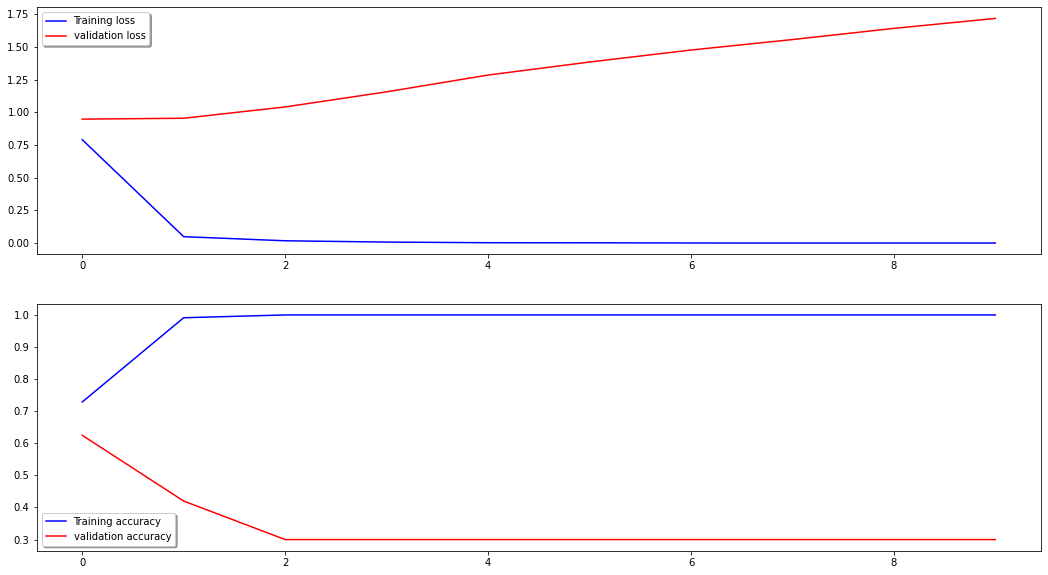

In [40]:
fig, ax = plt.subplots(2, 1, figsize = (18, 10))
ax[0].plot(history.history['loss'], color = 'b', label = "Training loss")
ax[0].plot(history.history['val_loss'], color = 'r', label = 'validation loss', axes = ax[0])
legend = ax[0].legend(loc = 'best', shadow = True)
ax[1].plot(history.history['accuracy'], color = 'b', label = 'Training accuracy')
ax[1].plot(history.history['val_accuracy'], color = 'r', label = 'validation accuracy')
legend = ax[1].legend(loc = 'best', shadow = True)